# Import Statements

In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import PIL
import matplotlib.pyplot as plt
import glob

# Reading the Metadata

In [3]:
root = "D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Complete Dataset"

In [4]:
metadata = pd.read_csv(root+"\HAM10000_metadata")

In [5]:
metadata['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [6]:
le = LabelEncoder()

In [7]:
le.fit(metadata['dx'])

LabelEncoder()

In [8]:
metadata['class_label']=le.transform(metadata['dx'])

In [9]:
metadata['class_label'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: class_label, dtype: int64

# Organising The Dataset

In [10]:
# classes=metadata['dx'].unique().tolist()

In [11]:
# import shutil

In [12]:
# source_dir="D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Complete Dataset\HAM10000_all_images"
# dest_dir="D:/IIIT-D/Summer Semester/CAPSTONE PROJECT/Complete Dataset/Class Wise Organised Images/"

In [13]:
# class_images=[]
# for i in tqdm(classes,):
#   if not os.path.exists(dest_dir + str(i) + "/"): 
#     os.mkdir(dest_dir + str(i) + "/")
#   image_ids = metadata[metadata['dx'] == i]['image_id']
#   class_images.extend(image_ids)
#   for id in tqdm(class_images):
#     if os.path.exists(dest_dir + i + "/"+id+".jpg"):
#       continue
#     else:
#       shutil.copyfile((source_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
#   class_images=[] 

# Train Test Split 

In [14]:
# !pip install split-folders tqdm

In [38]:
# import splitfolders
# input_folder = root+'/Class Wise Organised Images'
# output_folder = root+'/Train_Val_Test_Split'
# splitfolders.ratio(input=input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 10015 files [02:37, 63.56 files/s] 


# Build A Model

## Preprocessing

In [66]:
train_datagen = ImageDataGenerator(rescale= 1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

In [67]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
train_data = train_datagen.flow_from_directory(root+"/Train_Val_Test_Split/train",target_size=(224,224),batch_size=32,class_mode='categorical')

Found 8010 images belonging to 7 classes.


In [69]:
val_data = test_datagen.flow_from_directory(root+"/Train_Val_Test_Split/val",target_size=(224,224),batch_size=32,class_mode='categorical')

Found 998 images belonging to 7 classes.


In [70]:
test_data = test_datagen.flow_from_directory(root+"/Train_Val_Test_Split/test",target_size=(224,224),batch_size=32,class_mode='categorical')

Found 1007 images belonging to 7 classes.


# Building The CNN

In [71]:
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=[224, 224, 3],
                                               include_top=False,
                                               pooling="max",
                                               weights='imagenet')

In [102]:
VGG16_MODEL.trainable=False

In [109]:
VGG16_MODEL.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [103]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [110]:
prediction_layer = tf.keras.layers.Dense(7,activation='softmax')

In [111]:
model = tf.keras.Sequential([
  VGG16_MODEL,
  tf.keras.layers.Dense(units=4096, activation='relu'),
  tf.keras.layers.Dense(units=4096, activation='relu'),
  tf.keras.layers.Dense(units=4096, activation='relu'),
  prediction_layer
])

In [112]:
initial_learning_rate=0.001
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 5.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [113]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC(curve='ROC')],)

In [114]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_34 (Dense)             (None, 4096)              2101248   
_________________________________________________________________
dense_35 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_36 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_33 (Dense)             (None, 7)                 28679     
Total params: 50,407,239
Trainable params: 35,692,551
Non-trainable params: 14,714,688
_________________________________________________________________


In [117]:
%%time
from tensorflow.keras.callbacks import LearningRateScheduler

history = model.fit(x=train_data,
                    epochs=30, 
                    validation_data=val_data,
                    callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
251/251 [==============================] - 211s 840ms/step - loss: 0.9622 - accuracy: 0.6738 - auc_6: 0.9205 - val_loss: 0.8993 - val_accuracy: 0.6754 - val_auc_6: 0.9318
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
251/251 [==============================] - 112s 446ms/step - loss: 0.8976 - accuracy: 0.6841 - auc_6: 0.9309 - val_loss: 0.8527 - val_accuracy: 0.6914 - val_auc_6: 0.9386
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
251/251 [==============================] - 111s 443ms/step - loss: 0.8662 - accuracy: 0.6904 - auc_6: 0.9362 - val_loss: 0.8674 - val_accuracy: 0.6733 - val_auc_6: 0.9375
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
251/251 [==============================] - 112s 444ms/step - loss: 0.8531 - accuracy: 0.6939 - auc_6: 0.9380 - val_loss: 0.8267 - val_accuracy: 0.6854 - val_auc_6: 0.9

In [118]:
loss,accuracy,auc = model.evaluate(test_data)

print("loss: {}".format(loss))
print("accuracy: {}".format(accuracy))
print("AUC Score: {}".format(auc))

32/32 [==============================] - 16s 502ms/step - loss: 0.7583 - accuracy: 0.7368 - auc_6: 0.9509
loss: 0.7582792639732361
accuracy: 0.7368420958518982
AUC Score: 0.950880765914917


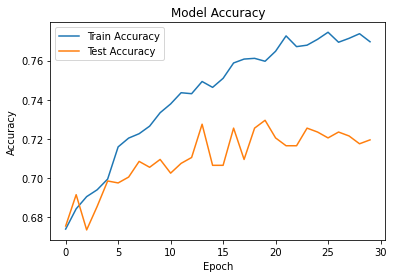

In [119]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

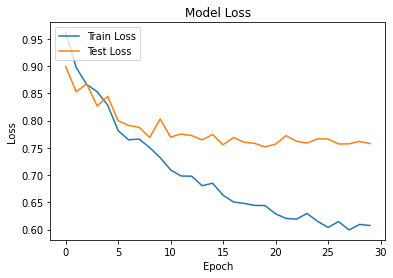

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

In [ ]:
# cnn.save('/content/drive/MyDrive/Capstone Project/Saved Models/first_model.h5')

In [ ]:
# from keras.models import load_model
# model = load_model("/content/drive/MyDrive/Capstone Project/Saved Models/first_model.h5")